In [1]:
from models.waffleiron.segmenter import Segmenter
import torch
from datasets import LIST_DATASETS, Collate
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from collections import OrderedDict
import warnings
import copy
import random
import numpy as np
import os

import argparse
import wandb
from torchmetrics.classification import MulticlassJaccardIndex
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import torchhd
from torchhd.models import Centroid
from torchhd import embeddings

class Encoder(nn.Module):
    def __init__(self, hd_dim, size):
        super(Encoder, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.projection = embeddings.Projection(size, hd_dim)
        self.projection.weight = nn.Parameter(torchhd.normalize(self.projection.weight), requires_grad=False) # Binary

    def forward(self, x):
        sample_hv = self.projection(x)
        return torchhd.hard_quantize(sample_hv)

class Feature_Extractor:
    def __init__(self, input_channels=5, feat_channels=768, depth=48, 
                 grid_shape=[[256, 256], [256, 32], [256, 32]], nb_class=16, layer_norm=True, 
                 device=torch.device("cpu"), early_exit = [48], **kwargs):
        self.model = Segmenter(
            input_channels=input_channels,
            feat_channels=feat_channels,
            depth=depth,
            grid_shape=grid_shape,
            nb_class=nb_class, # class for prediction
            #drop_path_prob=config["waffleiron"]["drop_path"],
            layer_norm=layer_norm,
            early_exit = early_exit
        )

        classif = torch.nn.Conv1d(
            feat_channels, nb_class, 1 # So it fits 16 = nb_class but classifier is not used
        )
        torch.nn.init.constant_(classif.bias, 0)
        torch.nn.init.constant_(classif.weight, 0)
        self.model.classif = torch.nn.Sequential(
            torch.nn.BatchNorm1d(feat_channels),
            classif,
        )

        for p in self.model.parameters():
            p.requires_grad = False
        for p in self.model.classif.parameters():
            p.requires_grad = True

        def get_optimizer(parameters):
            return torch.optim.AdamW(
                parameters,
                lr=0.001,
                weight_decay=0.003,
            )

        optim = get_optimizer(self.model.parameters())
        self.device = device
        self.device_string = "cuda:0" if (torch.cuda.is_available() and kwargs['args'].device == 'gpu') else "cpu"
        self.num_classes = nb_class
        self.early_exit = early_exit
        self.kwargs = kwargs
    
    def load_pretrained(self, path):
        # Load pretrained model
        path_to_ckpt = path
        checkpoint = torch.load(path_to_ckpt,
            map_location=self.device_string)
        state_dict = checkpoint["net"]  # Adjust key as needed
        new_state_dict = OrderedDict()

        for k, v in state_dict.items():
            new_key = k.replace("module.", "")  # Remove "module." prefix
            new_state_dict[new_key] = v

        self.model.load_state_dict(new_state_dict)

        print(
            f"Checkpoint loaded on {self.device_string}: {path_to_ckpt}"
        )

        if self.device_string != 'cpu':
            torch.cuda.set_device(self.device_string) # cuda:0
            self.model = self.model.cuda(self.device_string) # cuda:0

        self.model.eval()

        #self.model.waffleiron.crop_model(self.early_exit)

    def forward_model(self, it, batch, step_type):

        # Checking all of the parameters needed for feature extractor
        # Obj: only pass what you need
        feat = batch["feat"]
        labels = batch["labels_orig"]
        cell_ind = batch["cell_ind"]
        occupied_cell = batch["occupied_cells"]
        neighbors_emb = batch["neighbors_emb"]
        if self.device_string != 'cpu':
            feat = feat.cuda(0, non_blocking=True)
            labels = labels.cuda(0, non_blocking=True)
            batch["upsample"] = [
                up.cuda(0, non_blocking=True) for up in batch["upsample"]
            ]
            cell_ind = cell_ind.cuda(0, non_blocking=True)
            occupied_cell = occupied_cell.cuda(0, non_blocking=True)
            neighbors_emb = neighbors_emb.cuda(0, non_blocking=True)
        net_inputs = (feat, cell_ind, occupied_cell, neighbors_emb)

        if self.device_string != 'cpu':
            with torch.autocast("cuda", enabled=True):
                # Logits
                with torch.no_grad():
                    out = self.model(*net_inputs, step_type)
                    encode, tokens, out, exit_layer = out[0], out[1], out[2], out[3]
                    pred_label = out.max(1)[1]

                    # Only return samples that are not noise
                    #torch.cuda.synchronize(device=self.device)
                    where = labels != 255
                    #torch.cuda.synchronize(device=self.device)
        else:
            with torch.no_grad():
                out = self.model(*net_inputs, step_type)
                encode, tokens, out, exit_layer = out[0], out[1], out[2], out[3]
                pred_label = out.max(1)[1]

                # Only return samples that are not noise
                where = labels != 255

        return tokens[0,:,where], labels[where], pred_label[0, where], exit_layer

    def test(self, loader, total_voxels):        
        # Metric
        miou = MulticlassJaccardIndex(num_classes=self.num_classes, average=None).to(self.device, non_blocking=True)
        final_labels = torch.empty((total_voxels), device=self.device)
        final_pred = torch.empty((total_voxels), device=self.device)
        
        start_idx = 0
        for it, batch in tqdm(enumerate(loader), desc="SoA testing"):
            features, labels, soa_result = self.forward_model(it, batch)
            shape_sample = labels.shape[0]
            labels = labels.to(dtype = torch.int64, device = self.device, non_blocking=True)
            soa_result = soa_result.to(device=self.device, non_blocking=True)
            final_labels[start_idx:start_idx+shape_sample] = labels

            final_pred[start_idx:start_idx+shape_sample] = soa_result

            start_idx += shape_sample

        final_labels = final_labels[:start_idx]
        final_pred = final_pred[:start_idx]

        print("================================")

        print('Pred FE', final_pred, "\tShape: ", final_pred.shape)
        print('Label', final_labels, "\tShape: ", final_labels.shape)
        accuracy = miou(final_pred, final_labels)
        avg_acc = torch.mean(accuracy)
        print(f'accuracy: {accuracy}')
        print(f'avg acc: {avg_acc}')

        #cm = confusion_matrix(pred_hd, first_label, labels=torch.Tensor(range(0,15)))
        #print("Confusion matrix \n")
        #print(cm)

        print("================================")

class HD_Model:
    def __init__(self, in_dim, out_dim, num_classes, path_pretrained, 
                 device=torch.device("cpu"), **kwargs):

        encode = Encoder(out_dim, in_dim)
        self.encode = encode.to(device=device, non_blocking=True)

        model = Centroid(out_dim, num_classes)
        self.model = model.to(device=device, non_blocking=True)
        self.device = device
        self.feature_extractor = Feature_Extractor(nb_class = num_classes, device=self.device, 
                                                   early_exit=[int(i) for i in kwargs['args'].layers], 
                                                   args=kwargs['args'])
        self.feature_extractor.load_pretrained(path_pretrained)
        self.stop = kwargs['args'].layers
        self.point_per_iter = kwargs['args'].number_samples
        self.num_classes = num_classes
        self.max_samples = kwargs['args'].number_samples
        self.kwargs = kwargs
        self.compensation = None

    def normalize(self, samples):

        """ Normalize with Z-score"""

        mean = torch.mean(samples, dim=0)
        std = torch.std(samples, dim=0)

        samples = (samples - mean) / (std + 1e-8)

        return samples

    def set_loaders(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_vox_train = 0
        self.num_vox_val = 0

        for loader, desc, attr in [(self.train_loader, "Training loader", "num_vox_train"),
                           (self.val_loader, "Validation loader", "num_vox_val")]:
            for batch in tqdm(loader, desc=desc):
                labels = batch["labels_orig"]

                # Ensure labels are tensors
                if isinstance(labels, list):
                    labels = torch.stack(labels)  # Convert list of tensors to a single tensor
                
                # Move to GPU if applicable
                if self.device.type == "cuda":
                    labels = labels.cuda(non_blocking=True)

                # Compute the number of valid voxels
                setattr(self, attr, getattr(self, attr) + (labels != 255).sum().item())

        print("Finished loading data loaders")

    def set_compensation(self, inter_weights_path):

        """Load all the paths for every exit"""

        self.linear_weights = {}

        for layer, path in inter_weights_path.items():
            self.linear_weights[layer] = nn.Linear(768, 768)
            state_dict = torch.load(path)
            self.linear_weights[layer].load_state_dict(state_dict)
            self.linear_weights[layer] = self.linear_weights[layer].to(self.device)
        self.compensation = True
    
    def sample_to_encode(self, it, batch, step_type="train"):
        features, labels, soa_result, exit_layer = self.feature_extractor.forward_model(it, batch, step_type=step_type) # Everything for what hasn't been dropped
        features = torch.transpose(features, 0, 1).to(dtype=torch.float32, device = self.device, non_blocking=True)
        labels = labels.to(dtype=torch.int64, device = self.device, non_blocking=True)

        if self.compensation and exit_layer != 47:
            features = self.linear_weights[exit_layer](features)

        features = self.normalize(features) # Z1 score seems to work

        # HD training
        samples_hv = self.encode(features)

        return samples_hv, labels

/root/anaconda3/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using torch.scatter_reduce for 3D to 2D projection.
Using torch.scatter_reduce for 3D to 2D projection.


In [2]:
import argparse

def parse_dict_args(args_dict):
    parser = argparse.ArgumentParser()

    # Define arguments dynamically based on the dictionary keys
    for key, value in args_dict.items():
        if value is not None:
            arg_type = type(value)
            parser.add_argument(f'--{key}', type=arg_type, default=value)
        else:
            pass

    # Simulate command-line arguments
    args_list = [f'--{key}={value}' for key, value in args_dict.items()]
    
    return parser.parse_args(args_list)

og_args = {'confidence':1, 'number_samples': 500, 'add_lr': False, 
        "dataset":'nuscenes', "wandb_run":False, 'device':'gpu', 'dim':10000, 'batch_points':20000}

args = parse_dict_args(og_args)

args.seed = None
args.layers = ['24', '36']

# Set seed
if args.seed is not None:
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    os.environ["PYTHONHASHSEED"] = str(args.seed)

DIMENSIONS = args.dim
FEAT_SIZE = 768
NUM_LEVELS = 8000
BATCH_SIZE = 1  # for GPUs with enough memory we can process multiple images at ones

wandb.login(key="9487c04b8eff0c16cac4e785f2b57c3a475767d3")

device = torch.device("cuda" if (torch.cuda.is_available() and args.device == 'gpu') else "cpu")
print("Using {} device".format(device))
device_string = "cuda:0" if (torch.cuda.is_available() and args.device == 'gpu') else "cpu"

# Modify the path for each of the folders

if args.dataset == 'nuscenes':
    path = '/root/main/dataset/nuscenes'
elif args.dataset == 'semantic_kitti':
    path = '/root/main/dataset/semantickitti'
elif args.dataset == 'tls':
    path = '/root/main/dataset/tls'


# Get datatset
DATASET = LIST_DATASETS.get(args.dataset)

##### Process dataset #######

if args.dataset == 'nuscenes':

    kwargs = {
        "rootdir": path,
        "input_feat": ["intensity", "xyz", "radius"],
        "voxel_size": 0.1,
        "num_neighbors": 16,
        "dim_proj": [2, 1, 0],
        "grids_shape": [[256, 256], [256, 32], [256, 32]],
        "fov_xyz": [[-64, -64, -8], [64, 64, 8]], # Check here
    }

    # Train dataset
    dataset = DATASET(
        phase="train",
        **kwargs,
    )

    dataset_train = copy.deepcopy(dataset)
    dataset_val = copy.deepcopy(dataset)
    dataset_train.init_training()
    dataset_val.init_val()

    num_classes = 16

    path_pretrained = '/root/main/ScaLR/saved_models/ckpt_last_scalr.pth'

elif args.dataset == 'semantic_kitti':

    kwargs = {
        "rootdir": path,
        "input_feat": ["intensity", "xyz", "radius"],
        "voxel_size": 0.1,
        "num_neighbors": 16,
        "dim_proj": [2, 1, 0],
        "grids_shape": [[256, 256], [256, 32], [256, 32]],
        "fov_xyz": [[-64, -64, -8], [64, 64, 8]], # Check here
    }

    dataset_train = DATASET(
        phase="specific_train",
        **kwargs,
    )

    # Validation dataset
    dataset_val = DATASET(
        phase="val",
        **kwargs,
    )

    num_classes = 19

    path_pretrained = '/root/main/ScaLR/saved_models/ckpt_last_kitti.pth'

else:
    raise Exception("Dataset Not identified")

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    pin_memory=True,
    drop_last=True,
    collate_fn=Collate(device=device),
    persistent_workers=False,
)

val_loader = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    pin_memory=True,
    drop_last=True,
    collate_fn=Collate(device=device),
    persistent_workers=False,
)

hd_model = HD_Model(FEAT_SIZE, DIMENSIONS, num_classes, path_pretrained, device=device, args=args)
hd_model.set_loaders(train_loader=train_loader, val_loader=val_loader)


####### SOA results ##########
#print("SoA results")

#hd_model.feature_extractor.test(hd_model.val_loader, hd_model.num_vox_val+1000, 48)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: darthiv02 (darth-iv-02) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using cuda device
Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.670 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Checkpoint loaded on cuda:0: /root/main/ScaLR/saved_models/ckpt_last_scalr.pth


Validation loader: 100%|████████████████████████████████████████████████████████████████| 61/61 [00:45<00:00,  1.34it/s]

Finished loading data loaders


In [3]:
def train(hd_model):

    """ Initial training pass """

    print("\nTrain First\n")

    for it, batch in tqdm(enumerate(hd_model.train_loader), desc="Training"):

        samples_hv, labels = hd_model.sample_to_encode(it, batch, step_type="train")

        for b in range(0, samples_hv.shape[0], hd_model.point_per_iter):
            end = min(b + hd_model.point_per_iter, int(samples_hv.shape[0]))  # Ensure we don't exceed num_voxels[i]

        #samples_hv = samples_hv.reshape((1,samples_hv.shape[0]))

            hd_model.model.add(samples_hv[b:end], labels[b:end])

            #if self.device == torch.device("cuda:0"):
            #    torch.cuda.synchronize(device=self.device)
        if it == hd_model.max_samples:
            break

    hd_model.model.weight = nn.Parameter(torchhd.normalize(hd_model.model.weight), requires_grad=False) # Binary

    x = input("CKA values computed")

    threshold_values = []

    ## Get the threshold values
    for layer in hd_model.stop:
        np_cka = np.array([i.cpu() for i in hd_model.feature_extractor.model.waffleiron.cka_losses[int(layer)]])
        mean_cka = np.mean(np_cka)
        std_cka = np.std(np_cka)
        threshold = mean_cka - std_cka
        print("Threshold = ", threshold)
        hd_model.feature_extractor.model.waffleiron.set_exit_threshold(layer = layer, threshold = threshold)

def retrain(hd_model, epochs):

    """ Retrain with misclassified samples (also substract)"""

    for e in tqdm(range(epochs), desc="Epoch"):
        #count = 0
        #self.scramble = np.random.permutation(len(self.im_idx))
        
        num_wrong = []

        for it, batch in tqdm(enumerate(hd_model.train_loader), desc=f"Retraining epoch {e}"):

            samples_hv, labels = hd_model.sample_to_encode(it, batch, step_type="retrain")
            is_wrong_count = 0
            for b in range(0, samples_hv.shape[0], hd_model.point_per_iter):
                end = min(b + hd_model.point_per_iter, int(samples_hv.shape[0]))  # Ensure we don't exceed num_voxels[i]
                samples_hv_here = samples_hv[b:end]
                labels_here = labels[b:end]
                sim = hd_model.model(samples_hv_here, dot=True)
                #pred_hd = sim.argmax(1).data
                pred_hd = torch.argmax(sim, axis=1)

                is_wrong = labels_here != pred_hd
                
                is_wrong_count += sum(is_wrong)

                # cancel update if all predictions were correct
                if is_wrong.sum().item() == 0:
                    continue

                # only update wrongly predicted inputs
                samples_hv_here = samples_hv_here[is_wrong]
                labels_here = labels_here[is_wrong]
                pred_hd = pred_hd[is_wrong]

                #count = labels.shape[0]

                hd_model.model.weight.index_add_(0, labels_here, samples_hv_here)
                hd_model.model.weight.index_add_(0, pred_hd, samples_hv_here, alpha=-1.0)
            
            num_wrong.append(is_wrong_count)
            #torch.cuda.synchronize(device=self.device)

            if it == hd_model.max_samples:
                break

        #print(f"Misclassified for {it}: ", count)

        # If you want to test for each sample
        #hd_model.test_hd()
    
        return num_wrong

def test_hd(hd_model, loader='val'):

    """ Testing over all the samples in all the scans given """

    if loader == 'val':
        loader = hd_model.val_loader
        num_vox = hd_model.num_vox_val
    else:
        loader = hd_model.train_loader
        num_vox = hd_model.num_vox_train

    # Metric
    miou = MulticlassJaccardIndex(num_classes=hd_model.num_classes, average=None).to(hd_model.device, non_blocking=True)
    final_labels = torch.empty((num_vox+1000), dtype=torch.int64, device=hd_model.device)
    final_pred = torch.empty((num_vox+1000), dtype=torch.int64, device=hd_model.device)

    start_idx = 0
    for it, batch in tqdm(enumerate(loader), desc="Validation:"):

        samples_hv, labels = hd_model.sample_to_encode(it, batch, "Test") # Only return the features that haven't been dropped

        for b in range(0, samples_hv.shape[0], hd_model.point_per_iter):
            end = min(b + hd_model.point_per_iter, int(samples_hv.shape[0]))  # Ensure we don't exceed num_voxels[i]
            samples_hv_here = samples_hv[b:end]
            labels_here = labels[b:end]
            #torch.cuda.synchronize(device=self.device)

            shape_sample = labels_here.shape[0]

            #pred_hd = self.model(samples_hv, dot=True).argmax(1).data
            sim = hd_model.model(samples_hv_here, dot=True)
            #torch.cuda.synchronize(device=self.device)

            pred_hd = torch.argmax(sim, axis=1)
            #torch.cuda.synchronize(device=self.device)

            #print("Labels: ", labels.shape[0])
            #print(start_idx, start_idx+shape_sample)
            #print(shape_sample)

            final_labels[start_idx:start_idx+shape_sample] = labels_here
            final_pred[start_idx:start_idx+shape_sample] = pred_hd

            start_idx += shape_sample

        if it == hd_model.max_samples:
            break

    final_labels = final_labels[:start_idx]
    final_pred = final_pred[:start_idx]

    print("================================")

    #print('pred_ts', pred_ts)
    print('pred_hd', final_pred, "\tShape: ", final_pred.shape)
    print('label', final_labels, "\tShape: ", final_labels.shape)
    accuracy = miou(final_pred, final_labels)
    avg_acc = torch.mean(accuracy)
    print(f'accuracy: {accuracy}')
    print(f'avg acc: {avg_acc}')

    if args.wandb_run:
        log_data = {f"Training class_{i}_IoU": c for i, c in enumerate(accuracy)}
        log_data["Retraining epoch"] = avg_acc
        wandb.log(log_data)

    #cm = confusion_matrix(pred_hd, first_label, labels=torch.Tensor(range(0,15)))
    #print("Confusion matrix \n")
    #print(cm)

    print("================================")

In [4]:
hd_model.set_compensation({24: 'linear_weights_24_0.75.pth', 36: 'linear_weights_36_ep_0.75.pth'} )

if args.wandb_run:
    run = wandb.init(
        # Set the project where this run will be logged
        project="scalr_hd",
        # Track hyperparameters and run metadata
        config={
            "encoding": "Random Projection",
            "hd_dim": DIMENSIONS,
            "training_samples":args.number_samples,
        },
        id=f"{args.dataset}_training_layers_{args.layers}_norm_dim_{DIMENSIONS}_OFA_early_exit",
    )

####### HD Pipeline ##########

print("Initial Training")
train(hd_model)

Initial Training

Train First



Training: 0it [00:00, ?it/s]/home/HyperLiDAR/models/waffleiron/helper_projection.py:27: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1550.)
  residual.scatter_reduce_(
/tmp/ipykernel_7708/1220565487.py:36: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Training: 282it [05:14,  1.11s/it]


CKA values computed
Threshold =  nan
{24: nan}
Threshold =  nan
{24: nan, 36: nan}


/root/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
print("Testing")
test_hd(hd_model)

Testing


Validation:: 0it [00:00, ?it/s]/tmp/ipykernel_7708/1220565487.py:36: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Validation:: 61it [01:09,  1.13s/it]

pred_hd tensor([14, 14, 14,  ..., 15, 15, 15], device='cuda:0') 	Shape:  torch.Size([1020610])
label tensor([14, 14, 14,  ..., 15, 15, 15], device='cuda:0') 	Shape:  torch.Size([1020610])
accuracy: tensor([0.2682, 0.0025, 0.6463, 0.6179, 0.3442, 0.1557, 0.2829, 0.0689, 0.2128,
        0.4428, 0.7310, 0.1599, 0.3738, 0.4680, 0.6627, 0.7150],
       device='cuda:0')
avg acc: 0.384542316198349


In [35]:
num_wrong = retrain(hd_model, epochs=1)

Epoch:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]
Retraining epoch 0: 0it [00:00, ?it/s]/tmp/ipykernel_7708/1220565487.py:36: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)

Retraining epoch 0: 1it [00:01,  1.79s/it]
Retraining epoch 0: 2it [00:03,  1.73s/it]
Retraining epoch 0: 3it [00:04,  1.63s/it]
Retraining epoch 0: 4it [00:06,  1.74s/it]
Retraining epoch 0: 5it [00:08,  1.76s/it]
Retraining epoch 0: 6it [00:10,  1.68s/it]
Retraining epoch 0: 7it [00:11,  1.65s/it]
Retraining epoch 0: 8it [00:13,  1.70s/it]
Retraining epoch 0: 9it [00:15,  1.70s/it]
Retraining epoch 0: 10it [00:16,  1.67s/it]
Retraining epoch 0: 11it [00:18,  1.61s/it]
Retraining epoch 0: 12it [00:20,  1.65s/it]
Retraining epoch 0: 13it [00:21,  1.70s/it]
Retraining epoch 0: 14it [00:23,  1.65s/it]
Retraining epoch 0: 15it [00:25,  1.70s/it]
Retraining

Retraining epoch 0: 166it [04:23,  1.71s/it]
Retraining epoch 0: 167it [04:24,  1.76s/it]
Retraining epoch 0: 168it [04:26,  1.74s/it]
Retraining epoch 0: 169it [04:28,  1.75s/it]
Retraining epoch 0: 170it [04:30,  1.73s/it]
Retraining epoch 0: 171it [04:31,  1.73s/it]
Retraining epoch 0: 172it [04:33,  1.65s/it]
Retraining epoch 0: 173it [04:34,  1.65s/it]
Retraining epoch 0: 174it [04:36,  1.66s/it]
Retraining epoch 0: 175it [04:38,  1.68s/it]
Retraining epoch 0: 176it [04:39,  1.67s/it]
Retraining epoch 0: 177it [04:41,  1.70s/it]
Retraining epoch 0: 178it [04:43,  1.79s/it]
Retraining epoch 0: 179it [04:45,  1.83s/it]
Retraining epoch 0: 180it [04:47,  1.78s/it]
Retraining epoch 0: 181it [04:49,  1.77s/it]
Retraining epoch 0: 182it [04:50,  1.72s/it]
Retraining epoch 0: 183it [04:52,  1.72s/it]
Retraining epoch 0: 184it [04:54,  1.78s/it]
Retraining epoch 0: 185it [04:56,  1.78s/it]
Retraining epoch 0: 186it [04:57,  1.78s/it]
Retraining epoch 0: 187it [04:59,  1.75s/it]
Retraining

In [39]:
num_wrong

[MAPTensor(1430, device='cuda:0'),
 MAPTensor(1316, device='cuda:0'),
 MAPTensor(621, device='cuda:0'),
 MAPTensor(1895, device='cuda:0'),
 MAPTensor(1215, device='cuda:0'),
 MAPTensor(1278, device='cuda:0'),
 MAPTensor(1260, device='cuda:0'),
 MAPTensor(1606, device='cuda:0'),
 MAPTensor(1270, device='cuda:0'),
 MAPTensor(847, device='cuda:0'),
 MAPTensor(355, device='cuda:0'),
 MAPTensor(798, device='cuda:0'),
 MAPTensor(1477, device='cuda:0'),
 MAPTensor(422, device='cuda:0'),
 MAPTensor(1026, device='cuda:0'),
 MAPTensor(298, device='cuda:0'),
 MAPTensor(282, device='cuda:0'),
 MAPTensor(545, device='cuda:0'),
 MAPTensor(1652, device='cuda:0'),
 MAPTensor(396, device='cuda:0'),
 MAPTensor(1677, device='cuda:0'),
 MAPTensor(1125, device='cuda:0'),
 MAPTensor(2236, device='cuda:0'),
 MAPTensor(1382, device='cuda:0'),
 MAPTensor(2071, device='cuda:0'),
 MAPTensor(915, device='cuda:0'),
 MAPTensor(1374, device='cuda:0'),
 MAPTensor(461, device='cuda:0'),
 MAPTensor(361, device='cuda:0'

In [40]:
num_wrong_parse = np.array([int(i.cpu()) for i in num_wrong])
print(num_wrong_parse.shape)

(282,)


In [42]:
len(hd_model.feature_extractor.model.waffleiron.cka_losses[24])

564

In [23]:
cka_24 = hd_model.feature_extractor.model.waffleiron.cka_losses[24]
print("min: ", min(cka_24))
print("max: ", max(cka_24))
np_cka_24 = np.array([i.cpu() for i in cka_24])
print("std: ", np.std(np_cka_24))
print("mean: ", np.mean(np_cka_24))

min:  tensor(0.4104, device='cuda:0', dtype=torch.float64)
max:  tensor(0.5086, device='cuda:0', dtype=torch.float64)
std:  0.020707216622319693
mean:  0.4650592169123385


(282,)


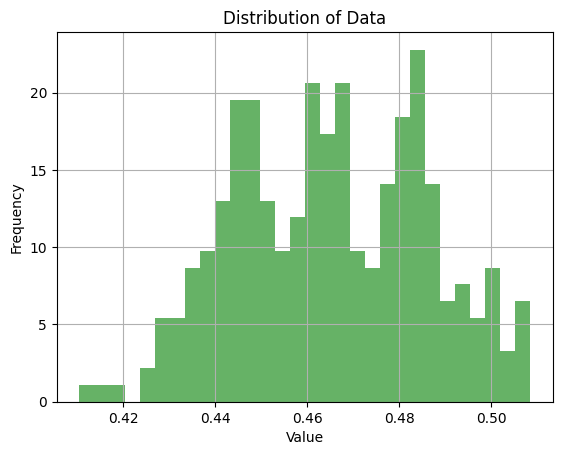

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np_cka_24
print(data.shape)

# Create a histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.grid(True)
plt.show()

In [12]:
np_cka_24_filt = np_cka_24 < np.mean(np_cka_24) - np.std(np_cka_24)

In [25]:
cka_36 = hd_model.feature_extractor.model.waffleiron.cka_losses[36]
print("min: ", min(cka_36))
print("max: ", max(cka_36))
np_cka_36 = np.array([i.cpu() for i in cka_36])
print("std: ", np.std(np_cka_36))
print("mean: ", np.mean(np_cka_36))

min:  tensor(0.6505, device='cuda:0', dtype=torch.float64)
max:  tensor(0.8405, device='cuda:0', dtype=torch.float64)
std:  0.04024422912890107
mean:  0.7511503923313992


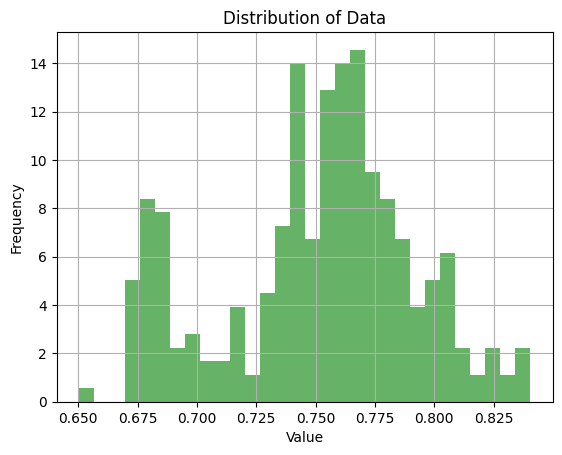

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np_cka_36

# Create a histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.grid(True)
plt.show()

In [15]:
np_cka_36_filt = np_cka_36 < np.mean(np_cka_36) - np.std(np_cka_36)

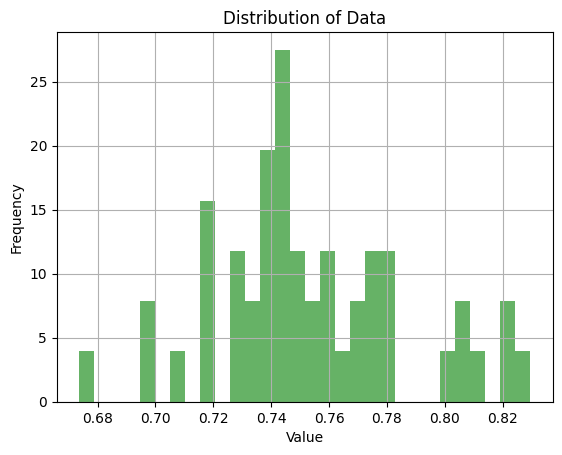

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np_cka_36[np_cka_24_filt]

# Create a histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.grid(True)
plt.show()

In [17]:
print(data.shape) ## Amount of values that are left

(49,)


In [18]:
np_cka_36[[i & j for i,j in zip(np_cka_24_filt, np_cka_36_filt)]].shape

(4,)

## Get num_wrong

In [37]:
num_wrong_parse.shape

(282,)

In [43]:
cka_24 = hd_model.feature_extractor.model.waffleiron.cka_losses[24][-282:]
print("min: ", min(cka_24))
print("max: ", max(cka_24))
np_cka_24 = np.array([i.cpu() for i in cka_24])

min:  tensor(0.4104, device='cuda:0', dtype=torch.float64)
max:  tensor(0.5086, device='cuda:0', dtype=torch.float64)


In [44]:
cka_36 = hd_model.feature_extractor.model.waffleiron.cka_losses[36][-282:]
print("min: ", min(cka_36))
print("max: ", max(cka_36))
np_cka_36 = np.array([i.cpu() for i in cka_36])

min:  tensor(0.6505, device='cuda:0', dtype=torch.float64)
max:  tensor(0.8405, device='cuda:0', dtype=torch.float64)


In [45]:
np_cka_36.shape

(282,)

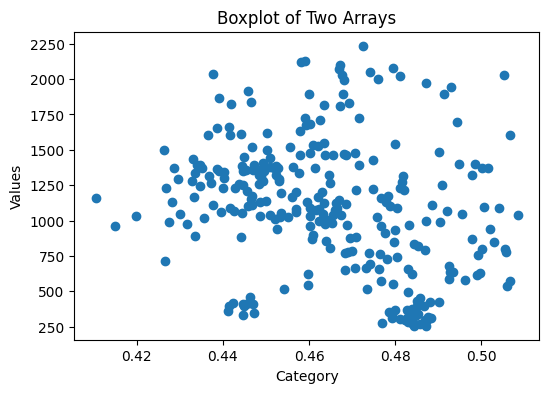

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example Data
x = np_cka_24
  # Categories
y = num_wrong_parse  # Values

# Create the Boxplot
plt.figure(figsize=(6, 4))
plt.plot(x, y, linestyle='', marker='o')

# Labels and Title
plt.xlabel("Category")
plt.ylabel("Values")
plt.title("Boxplot of Two Arrays")

# Show the Plot
plt.show()

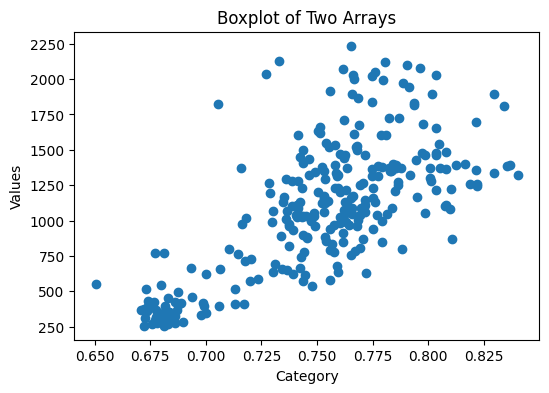

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example Data
x = np_cka_36
  # Categories
y = num_wrong_parse  # Values

# Create the Boxplot
plt.figure(figsize=(6, 4))
plt.plot(x, y, linestyle='', marker='o')

# Labels and Title
plt.xlabel("Category")
plt.ylabel("Values")
plt.title("Boxplot of Two Arrays")

# Show the Plot
plt.show()

In [55]:
np.save('num_wrong_epoch_1.np', num_wrong_parse)

In [56]:
np.save('np_cka_36_epoch_1.np', np_cka_36)
np.save('np_cka_24_epoch_1.np', np_cka_36)